In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

https://colab.research.google.com/drive/1FYQemqQ31awvAj3iKHOOabSqnMI4hMXJ?usp=sharing

In [2]:
!pip install orbit-ml

     |████████████████████████████████| 112kB 24.3MB/s 
     |████████████████████████████████| 11.6MB 36.5MB/s 
     |████████████████████████████████| 9.5MB 52.2MB/s 
     |████████████████████████████████| 634kB 32.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
!pip install prophet

     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 184kB 29.2MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6639487 sha256=9eb2f897ccb83161184c9e124cdaa0eb6ac2ef81d874fb09b782a68929b45f22
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [4]:
!pip install sktime[all_extras]

     |████████████████████████████████| 5.7MB 14.3MB/s 
     |████████████████████████████████| 22.3MB 1.6MB/s 
     |████████████████████████████████| 1.5MB 41.6MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 788kB 38.6MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 194kB 53.1MB/s 
     |████████████████████████████████| 706kB 42.3MB/s 
     |████████████████████████████████| 1.1MB 31.4MB/s 
     |████████████████████████████████| 378kB 49.6MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 16.9MB 353kB/s 
     |████████████████████████████████| 1.3MB 31.2MB/s 
     |████████████████████████████████| 

# Данные

The iclaims data contains the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job)from Jan 2010 - June 2018.

An initial claim is a claim filed by an unemployed individual after a separation from an employer. The claim requests a determination of basic eligibility for the Unemployment Insurance program.

Number of claims are obtained from Federal Reserve Bank of St. Louis while regressors such as google queries are obtained through Google Trends API.

Note: Both the response and regressors are transformed by log in order to illustrate a multiplicative model. We will continue to use this dataset in some subsequent sections.

Source: https://orbit-ml.readthedocs.io/en/latest/tutorials/quick_start.html?highlight=load_iclaims#Data

In [2]:
from orbit.utils.dataset import load_iclaims

df = load_iclaims()
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


Построим графики всех колонок в таблице. Наша целевая колонка - **claims**. Именно ее мы будем прогнозировать.

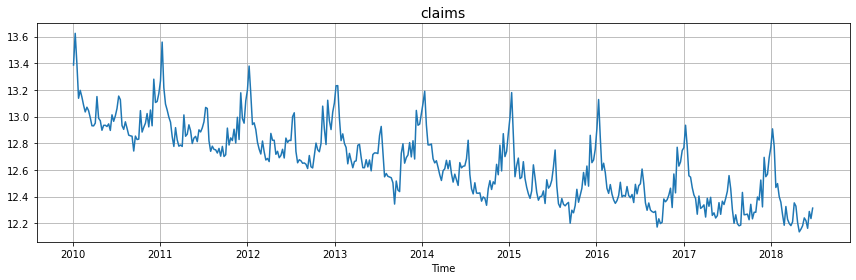

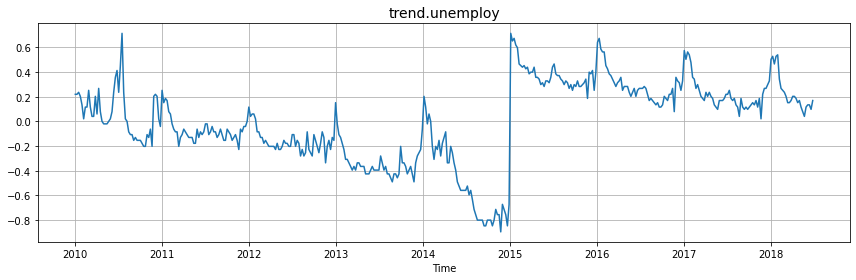

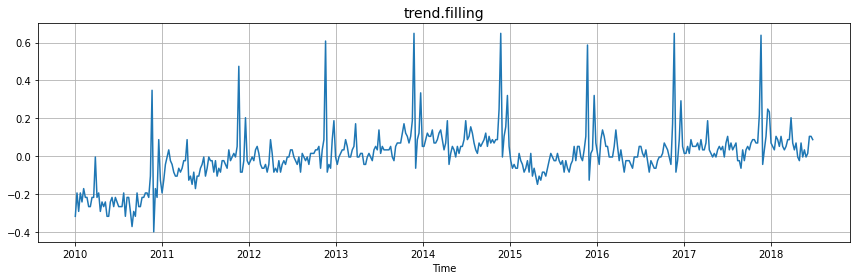

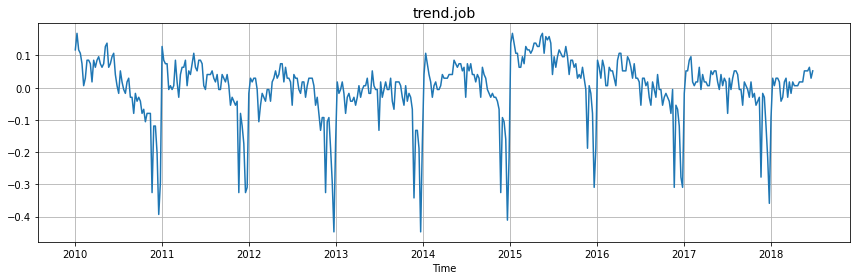

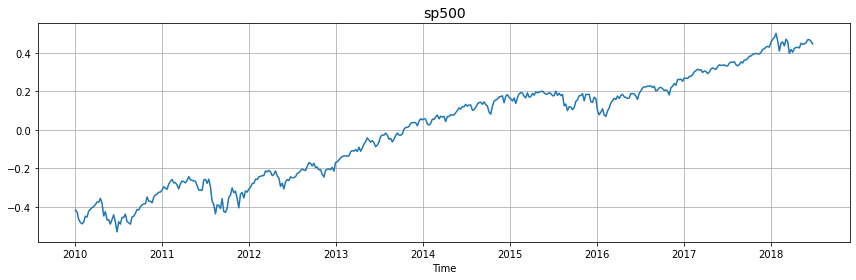

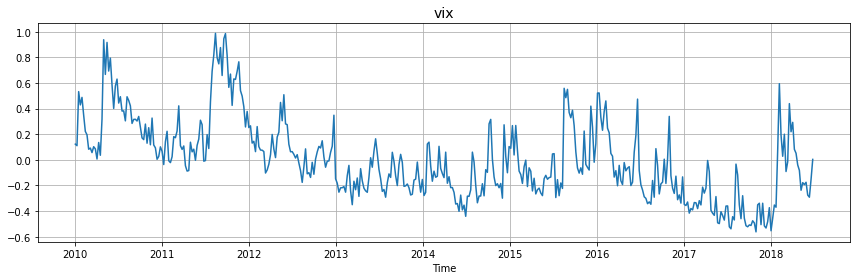

In [3]:
for fname in df.columns[1:]:
  plt.figure(figsize=(12, 4))
  plt.plot(df['week'].values, df[fname].values)
  plt.xlabel('Time')
  plt.title(fname, size=14)
  plt.grid(b=1)
  plt.tight_layout()
  plt.show()

## Train / Test split

Возьмем наблюдения за последние 2 года в качестве тестовой выборки. Соотвественно, данные за первые 6 лет будем использовать для обучения наших моделей.

In [4]:
test_size = 52*2 # два последних года

train_df = df[:-test_size]
test_df  = df[-test_size:]

# Orbit (без сахара)

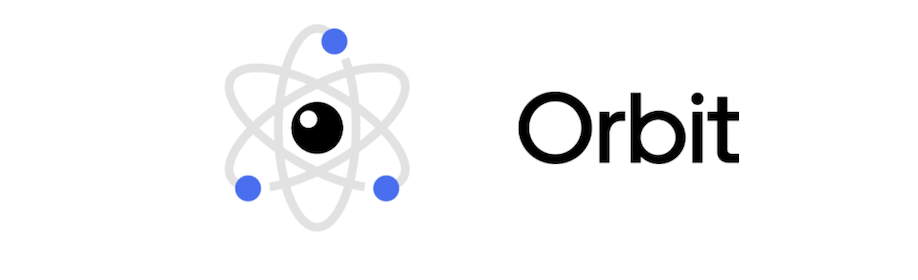

Сссылка: https://github.com/uber/orbit

# Damped Local Trend (DLT)

Уравнения модели для прогноза:

$$
y_t = \mu_t + s_t + r_t + \epsilon_t
$$
$$
\mu_t = g_t + l_{t-1} + \theta b_{t-1}
$$
$$
\epsilon_t \sim \text{Student}(\nu, 0, \sigma)
$$
$$
\sigma \sim \text{HalfCauchy}(0, \gamma_0)
$$

Уравнения для обновления:

$$
g_t = D(t)
$$
$$
l_t = \rho_l(y_t - g_t - s_t - r_t) + (1 - \rho_l)(l_{t-1}+\theta b_{t-1})
$$
$$
b_t = \rho_b(l_t - l_{t-1}) + (1 - \rho_b)\theta b_{t-1}
$$
$$
s_{t+m} = \rho_s(y_t - l_{t}-r_t) + (1 - \rho_s)s_t
$$
$$
r_{t} = \sum_{j}\beta_jx_{jt}
$$

где 
- $\rho_{l}$, $\rho_{b}$, $\rho_{s}$ - гиперпараметры модели; 
- $l_t$ - сглаженное значение временного ряда (англ. level); 
- $b_t$ - тренд временного ряда;
- $s_t$ - сезоннная компонента ряда; 
- $g_t$ - детерминированный процесс тренда; 
- $r_t$ - регрессор модели; 
- $\beta_j \sim N(\mu_j, \sigma_j^2)$ - коэффициенты регрессора;
- $x_{jt}$ - признаки наблюдений;


Источник: https://orbit-ml.readthedocs.io/en/stable/tutorials/dlt.html

Документация: https://orbit-ml.readthedocs.io/en/stable/orbit.models.html?highlight=DLTFull#orbit.models.dlt.DLTFull

In [5]:
from orbit.models.dlt import DLTFull

# инициализируем модель
dlt = DLTFull(
    response_col='claims', 
    date_col='week',
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=52,
)

# обучаем модель
dlt.fit(df=train_df)

# делаем прогноз
predicted_df = dlt.predict(df=test_df)

# выводим таблицу прогноза
predicted_df.head()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0a449c7523386cce384e92a998e71c8 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,week,prediction_5,prediction,prediction_95
0,2016-07-03,12.481586,12.585820,12.685109
1,2016-07-10,12.622982,12.709627,12.794462
2,2016-07-17,12.346069,12.452392,12.564704
3,2016-07-24,12.233712,12.316029,12.410098
4,2016-07-31,12.183137,12.291820,12.376168


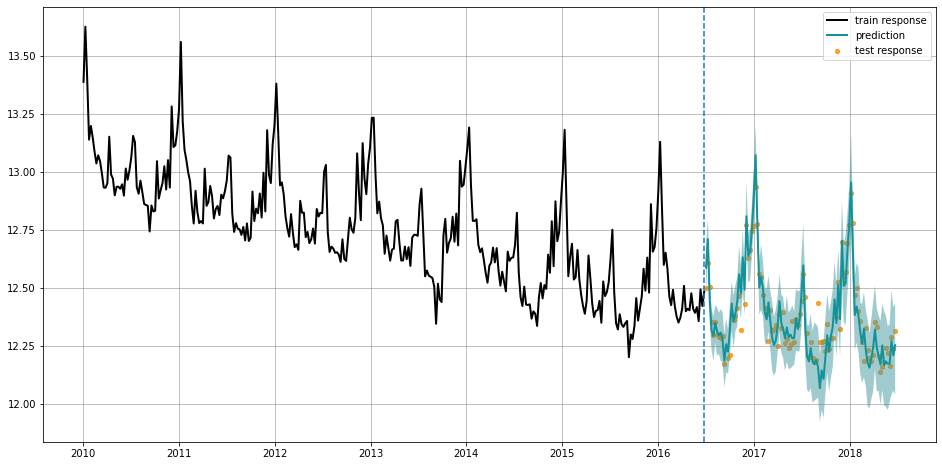

<AxesSubplot:>

In [6]:
# построим график прогноза с доверительными интервалами
from orbit.diagnostics.plot import plot_predicted_data


plot_predicted_data(
    training_actual_df=train_df, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=test_df, insample_line=True
)

### Метрики качества прогноза

**1. (R)MSE ((Root) Mean Squared Error)**

$$ L(\hat{y}, y) = \sqrt{\frac{1}{N}\sum\limits_{n=1}^N (y_n - \hat{y}_n)^2}$$

**2. MAE (Mean Absolute Error)**

$$ L(\hat{y}, y) = \frac{1}{N}\sum\limits_{n=1}^N |y_n - \hat{y}_n|$$

**3. RSE (Relative Squared Error)**

$$ L(\hat{y}, y) = \sqrt\frac{\sum\limits_{n=1}^N (y_n - \hat{y}_n)^2}{\sum\limits_{n=1}^N (y_n - \bar{y})^2}$$

**4. RAE (Relative Absolute Error)**

$$ L(\hat{y}, y) = \frac{\sum\limits_{n=1}^N |y_n - \hat{y}_n|}{\sum\limits_{n=1}^N |y_n - \bar{y}|}$$

**5. MAPE (Mean Absolute Persentage Error)**

$$ L(\hat{y}, y) = \frac{100}{N} \sum\limits_{n=1}^N\left|\frac{ y_n - \hat{y}_n}{y_n}\right|$$


**6. RMSLE (Root Mean Squared Logarithmic Error)**

$$ L(\hat{y}, y) = \sqrt{\frac{1}{N}\sum\limits_{n=1}^N(\log(y_n + 1) - \log(\hat{y}_n + 1))^2}$$

In [7]:
def regression_quality_metrics_report(y_true, y_pred):
    
    rmse = # your code here
    mae = # your code here
    rse = # your code here
    rae = # your code here
    mape = # your code here
    rmsle = # your code here
    
    return [rmse, mae, rse, rae, mape, rmsle]

In [ ]:
metrics_report = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'RMSLE'])

metrics_report.loc['DLT', :] = regression_quality_metrics_report(test_df['claims'].values, predicted_df['prediction'].values)

metrics_report

,RMSE,MAE,RSE,RAE,MAPE,RMSLE
DLT,0.068871,0.0498002,0.391731,0.366663,0.401949,0.00515083


# Задание

По аналогии с предыдущим примером сделайте прогноз ряда с помощью **Local Global Trend (LGT)**. Какое качество прогноза по сравнению с DLT моделью?

Подсказка: используйте `from orbit.models.lgt import LGTFull`. Описание модели приведено в https://orbit-ml.readthedocs.io/en/stable/tutorials/lgt.html.

In [ ]:
# Введите ваш код после гудка. Бииииип!

# Prophet

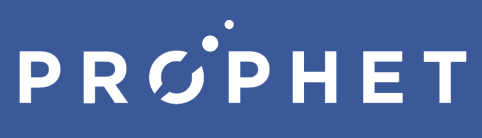

Ссылка: https://facebook.github.io/prophet/

Для начала нам необходимо привести наш временной ряд к нужному формату.

In [ ]:
train_df_prophet = train_df[['week', 'claims', 'trend.unemploy', 'trend.filling', 'trend.job']]
train_df_prophet.columns = ['ds', 'y', 'trend.unemploy', 'trend.filling', 'trend.job']

train_df_prophet.head()

,ds,y,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483


In [ ]:
from prophet import Prophet

# инициализируем модель
model = Prophet(interval_width=0.9)

# добавляем регрессоры
model.add_regressor('trend.unemploy')
model.add_regressor('trend.filling')
model.add_regressor('trend.job')

# обучаем модель
model.fit(train_df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Теперь, мы готовы делать прогноз. Но перед этим нам нужно снова привести данные в нужный формат.

In [ ]:
future = test_df[['week', 'trend.unemploy', 'trend.filling', 'trend.job']]
future.columns = ['ds', 'trend.unemploy', 'trend.filling', 'trend.job']

future.head()

,ds,trend.unemploy,trend.filling,trend.job
339,2016-07-03,0.267891,0.051295,-0.054350
340,2016-07-10,0.267891,0.014254,0.029532
341,2016-07-17,0.283396,-0.004795,0.029532
342,2016-07-24,0.267891,0.032946,0.006275
343,2016-07-31,0.219882,-0.024213,0.017971


In [ ]:
# делаем прогноз на указанные даты
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2016-07-03,12.550327,12.435297,12.670497
1,2016-07-10,12.578204,12.460574,12.683758
2,2016-07-17,12.509311,12.394366,12.619452
3,2016-07-24,12.396633,12.281506,12.521112
4,2016-07-31,12.300111,12.188444,12.416739


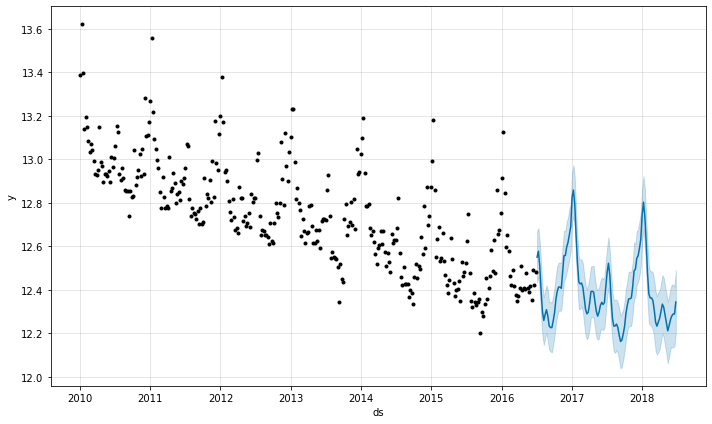

In [ ]:
# отображаем прогноз на требуемые даты
fig1 = model.plot(forecast)

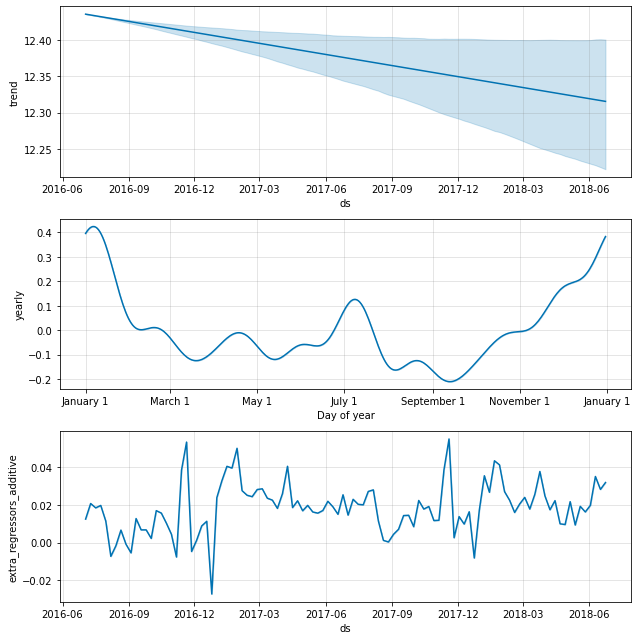

In [ ]:
# даже можем вывести компоненты прогноза
fig2 = model.plot_components(forecast)

In [ ]:
# посчитаем метрики качества прогноза
metrics_report.loc['Prophet', :] = regression_quality_metrics_report(test_df['claims'].values, forecast['yhat'].values)

metrics_report

,RMSE,MAE,RSE,RAE,MAPE,RMSLE
DLT,0.068871,0.0498002,0.391731,0.366663,0.401949,0.00515083
Prophet,0.0713324,0.0538267,0.405731,0.396309,0.435156,0.00532927


# Задание

Попробуйте добавить **sp500** и **vix** в качестве регрессоров. Помогло ли это улучшить качество прогноза? 

In [ ]:
# Разыскивается ваш код! Награда: 500 кармических ништяков

# Sktime

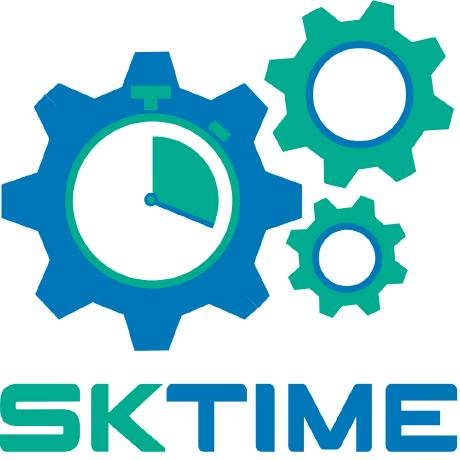

Ссылка: https://github.com/alan-turing-institute/sktime

# AutoARIMA

AutoARIMA осуществляет автоматический подбор параметров модели (S)ARIMA. ARIMA - это комбинация авторегрессионной модели AR, скользящего среднего MA и дифференцирования временного ряда I. Объяснить эту модель картинкой или парой формул не получится :( Поэтому приведем ссылку на отличный учебник: https://otexts.com/fpp3/arima.html


(S)ARIMA задается семью параметрами: (p, d, q) для прогноза очищенного от сезонности ряда, (P, D, Q)m для прогноза сезонной компоненты временного ряда. А именно:

- p - число предыдущих значений ряда в авторегрессионной AR модели;
- d - порядок дифференцирования входного ряда;
- q - порядо MA модели скользящего среднего;
- P - число предыдущих значений ряда в авторегрессионной AR модели для сезонной компоненты;
- D - порядок дифференцирования входного ряда для сезонной компоненты;
- Q - порядо MA модели скользящего среднего для сезонной компоненты;
- m - число измерений в одном периоде. В нашем случае m=52.

Документация: https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.AutoARIMA.html#sktime.forecasting.arima.AutoARIMA

Вы можете предположить, что формат данных у этой библиотеки должен быть похож на предыдущие примеры. Но нет. Данные здесь подаются совсем по-другому. :(

Поэтому наш первый шаг - привести наш верменной ряд к нужному формату. 

In [ ]:
# преобразуем pd.DataFrame в pd.Series
trains_ts = pd.Series(data=train_df['claims'].values, index=train_df['week'].values)
trains_ts.index.freq="W"

Теперь мы готовы обучить нашу модель.

In [ ]:
%%time
from sktime.forecasting.arima import AutoARIMA

# инициализация модели
# ВНИМАНИЕ: если взять более широкие границы параметров, то обучение займет очень много времени и ОЗУ (AutoARIMA не болей)
forecaster = AutoARIMA(start_p=1, d=None, start_q=0, 
                       max_p=2, max_d=1, max_q=0, 
                       start_P=1, D=1, start_Q=0, 
                       max_P=1, max_D=1, max_Q=0, 
                       sp=52, suppress_warnings=True, stepwise=False, n_jobs=-1)

# обучение модели
forecaster.fit(trains_ts)

CPU times: user 2.46 s, sys: 3.92 s, total: 6.38 s
Wall time: 1min 2s


In [ ]:
# посмотрим какие параметры являются оптимальными
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  339
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 52)   Log Likelihood                 371.893
Date:                            Wed, 19 May 2021   AIC                           -733.786
Time:                                    19:47:16   BIC                           -715.488
Sample:                                         0   HQIC                          -726.453
                                            - 339                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0852      0.011     -7.699      0.000      -0.107      -0.064
ar.L1          0.1451      0.043      3.377      0.001       0.061       0.229
ar.L2          0.1358      0.052      2.623      0.009       0.034       0.237
ar.S.L52      -0.2353      0.054     -4.382      0.000      -0.340      -0.130
sigma2         0.0043      0.000     20.812      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               372.20
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Теперь переведем данные тестирования в нужный формат, чтобы мы смогли сделать прогноз. И, собственно, сделаем прогноз!

In [ ]:
from sktime.forecasting.base import ForecastingHorizon

# pd.DataFrame -> pd.Series
test_ts = pd.Series(data=test_df['claims'].values, index=test_df['week'].values)
test_ts.index.freq="W"

# о да! для погноза свой формат
fh = ForecastingHorizon(test_ts.index, is_relative=False)

In [ ]:
# получаем прогноз и доверительные интервалы
y_pred, y_intervals = forecaster.predict(fh, return_pred_int=True)

In [ ]:
# так выглядит прогноз
y_pred.head()

2016-07-03    12.530217
2016-07-10    12.657142
2016-07-17    12.384593
2016-07-24    12.256647
2016-07-31    12.225692
dtype: float64

In [ ]:
# так выглядят доверительные интервалы
y_intervals.head()

,lower,upper
2016-07-03,12.401113,12.659321
2016-07-10,12.526686,12.787599
2016-07-17,12.252573,12.516612
2016-07-24,12.124514,12.388780
2016-07-31,12.093511,12.357872


Переведем полученный прогноз в удобный для нас формат. Этот формат аналогичен тому, что мы использовали в примере с orbit.

In [ ]:
predicted_df_arima = pd.DataFrame()
predicted_df_arima['week'] = test_df['week']
predicted_df_arima['prediction_5'] = y_intervals['lower'].values
predicted_df_arima['prediction'] = y_pred.values
predicted_df_arima['prediction_95'] = y_intervals['upper'].values

predicted_df_arima.head()

,week,prediction_5,prediction,prediction_95
339,2016-07-03,12.401113,12.530217,12.659321
340,2016-07-10,12.526686,12.657142,12.787599
341,2016-07-17,12.252573,12.384593,12.516612
342,2016-07-24,12.124514,12.256647,12.388780
343,2016-07-31,12.093511,12.225692,12.357872


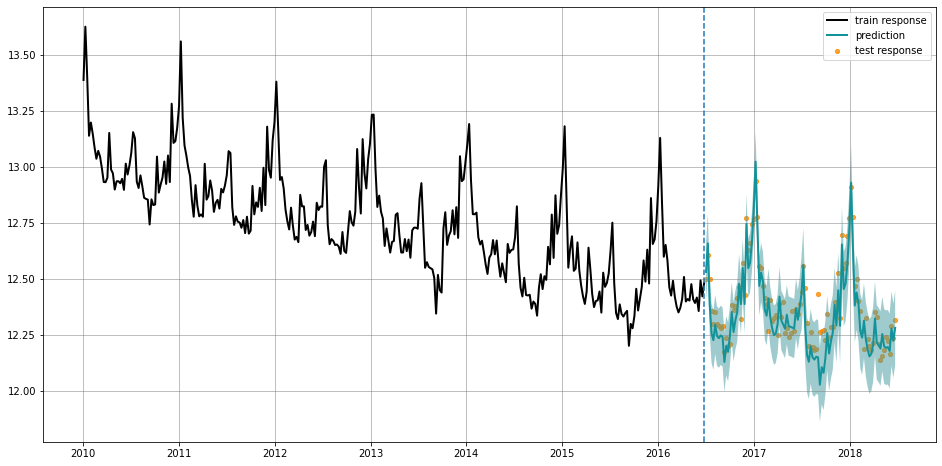

<AxesSubplot:>

In [ ]:
# нарисуем прогноз и доверительные интервалы
plot_predicted_data(
    training_actual_df=train_df, predicted_df=predicted_df_arima,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=test_df, insample_line=True
)

In [ ]:
# посчитаем метрики качества прогноза
metrics_report.loc['AutoARIMA', :] = regression_quality_metrics_report(test_df['claims'].values, predicted_df_arima['prediction'].values)

metrics_report

,RMSE,MAE,RSE,RAE,MAPE,RMSLE
DLT,0.068871,0.0498002,0.391731,0.366663,0.401949,0.00515083
Prophet,0.0713324,0.0538267,0.405731,0.396309,0.435156,0.00532927
AutoARIMA,0.0776302,0.0610038,0.441552,0.449152,0.492424,0.00582384


# AutoETS

# Задание

По аналогии с AutoARIMA сделайте прогноз временного ряда с помощью **AutoETS**. Сравните эту модель с остальными по качеству прогноза.

Подсказка: используйте `from sktime.forecasting.ets import AutoETS`. Документация и пример доступен тут https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.ets.AutoETS.html#sktime.forecasting.ets.AutoETS

In [ ]:
# Ваш код может быть размещен здесь. Справки по телефону: +7 985 112 35 813